# 0. Ready for Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d /content/nlp/

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 1.04GB/s]
Archive:  nlp-getting-started.zip
  inflating: /content/nlp/sample_submission.csv  
  inflating: /content/nlp/test.csv   
  inflating: /content/nlp/train.csv  


In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
open

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
np.random.seed(20211001)
tf.random.set_seed(20211001)

# 1. Problem & Data

## 1.1 Problem Definition

- This problem is to build a Natural Language Processing model that analyzes the text of tweets to classify whether they are about a real disaster or not<b>("Korean-To-English Translation")</b>.




## 1.2 Data Description

* This is a dataset of approximately 10,000 manually classified tweets.

* It consists of train.csv for model training and test.csv as the test dataset. (There is also sample_submission.csv for submissions.)

* train.csv has 7,613 rows and 5 columns (id, keyword, location, text, target).

 * id: a unique identifier for each tweet

 * keyword: a keyword from the tweet

 * location: the location where the tweet was sent from

 * text: the original text of the tweet

 * target: 1 for a real disaster tweet, 0 for a non-disaster tweet

* test.csv has 3,263 rows and 4 columns (id, keyword, location, text)<b>("Korean-To-English Translation")</b>.


In [4]:
train_df = pd.read_csv('/content/nlp/train.csv')
test_df = pd.read_csv('/content/nlp/test.csv')
sample_submission = pd.read_csv('/content/nlp/sample_submission.csv')

In [5]:
train_df.shape

(7613, 5)

In [6]:
test_df.shape

(3263, 4)

In [7]:
train_df.columns.tolist()

['id', 'keyword', 'location', 'text', 'target']

In [8]:
test_df.columns.tolist()

['id', 'keyword', 'location', 'text']

In [9]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# 2. EDA

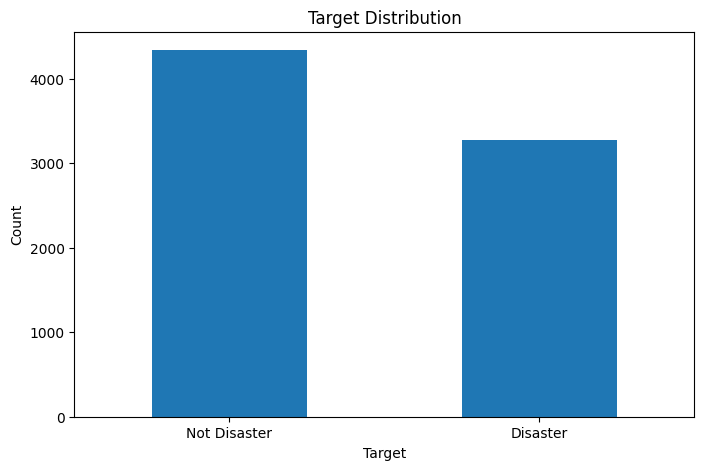

In [11]:
plt.figure(figsize=(8, 5))
train_df['target'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)
plt.show()

In [12]:
train_df['target'].value_counts() # count

,count
target,
0,4342
1,3271


In [13]:
train_df['target'].value_counts() / len(train_df) # ratio

,count
target,
0,0.57034
1,0.42966


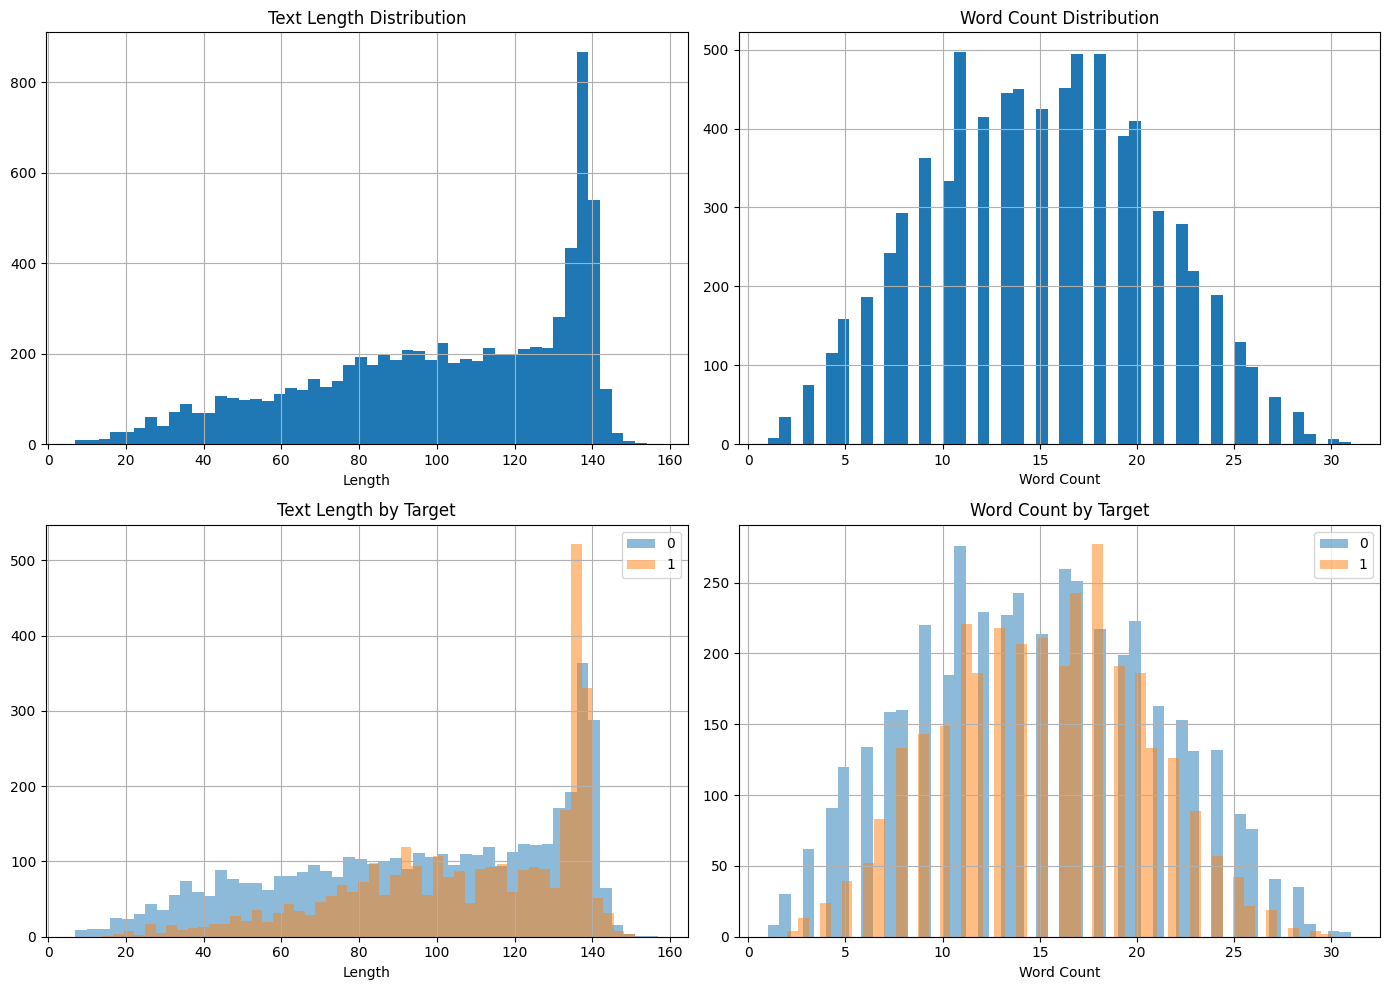

In [14]:
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

train_df['text_length'].hist(bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].set_xlabel('Length')

train_df['word_count'].hist(bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].set_xlabel('Word Count')

train_df.groupby('target')['text_length'].hist(bins=50, alpha=0.5, ax=axes[1, 0], legend=True)
axes[1, 0].set_title('Text Length by Target')
axes[1, 0].set_xlabel('Length')

train_df.groupby('target')['word_count'].hist(bins=50, alpha=0.5, ax=axes[1, 1], legend=True)
axes[1, 1].set_title('Word Count by Target')
axes[1, 1].set_xlabel('Word Count')

plt.tight_layout()
plt.show()

In [15]:
train_df.isnull().sum() # missing values in train

,0
id,0
keyword,61
location,2533
text,0
target,0
text_length,0
word_count,0


In [16]:
test_df.isnull().sum() # missing values in test

,0
id,0
keyword,26
location,1105
text,0


In [17]:
def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove URL
    text = re.sub(r'<.*?>', '', text) # remove HTML things
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub(r'\n', ' ', text) # replace newlines with space
    text = re.sub(r'\d+', '', text) # remove numbers
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [18]:
X = train_df['cleaned_text'].values
y = train_df['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20211001, stratify=y)

In [19]:
len(X_train) # train size

6090

In [20]:
len(X_val) # valid size

1523

# 3. Architecture

* LSTM (Long Short-Term Memory) was selected. In a standard RNN, as a sequence gets longer, the gradient from the initial information can vanish as it's passed to later steps. This results in a "short-term memory" problem where the model effectively "forgets" important words from the beginning of the sequence. LSTM, with its cell state and three gates, can retain information over longer periods, allowing it to effectively capture the context of long sequences.<b>("Korean-To-English Translation")</b>

* WWord2Vec: This is a type of word embedding technique. Embedding is the process of converting natural language into multi-dimensional vectors so that a model can understand and process it, as raw text cannot be fed into the input nodes of a network. The core idea behind Word2vec is that "words that appear in similar contexts have similar meanings(Yoo, 2022)"

 * Word2vec has two primary models: CBOW (Continuous Bag-of-Words) and Skip-gram. CBOW uses the surrounding context words as input to predict a single word in the center. Conversely, Skip-gram uses a single central word as input to predict the surrounding context words (Mikolov et al., 2013).

 * Word2vec utilizes a single projection layer. Mikolov et al. (2013) argued that since most of the complexity in previous models came from the non-linear hidden layers, they opted for a single linear layer without a non-linear activation function. In other words, the goal is not the final output (probabilities) of the neural network, but rather the network's weights that are learned during the training process<b>("Korean-To-English Translation")</b>.

In [21]:
MAX_WORDS = 10000
MAX_LEN = 100

sentences = [text.split() for text in train_df['cleaned_text'].values]
EMBEDDING_DIM = 128
w2v_model = Word2Vec(sentences,
                     vector_size=EMBEDDING_DIM,
                     window=5,
                     min_count=1,
                     workers=4,
                     epochs=10)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'].values)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, idx in tokenizer.word_index.items():
    if idx < MAX_WORDS:
        try:
            embedding_matrix[idx] = w2v_model.wv[word]
        except KeyError:
            embedding_matrix[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

In [22]:
def lstm_model(embedding_dim=128, lstm_units=64, dropout_rate=0.5):
    model = keras.Sequential([
        layers.Input(shape=(MAX_LEN,)),
        layers.Embedding(MAX_WORDS, embedding_dim,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix],
                        trainable=False),
        layers.SpatialDropout1D(0.2),
        layers.LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True),
        layers.LSTM(lstm_units//2, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model = lstm_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,913 (5.12 MB)

 Trainable params: 62,913 (245.75 KB)

 Non-trainable params: 1,280,000 (4.88 MB)

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001
)

history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 91s 428ms/step - accuracy: 0.5652 - loss: 0.6882 - val_accuracy: 0.5706 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 426ms/step - accuracy: 0.5835 - loss: 0.6832 - val_accuracy: 0.5706 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 432ms/step - accuracy: 0.5830 - loss: 0.6816 - val_accuracy: 0.5706 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 430ms/step - accuracy: 0.5831 - loss: 0.6811 - val_accuracy: 0.5706 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 430ms/step - accuracy: 0.5830 - loss: 0.6798 - val_accuracy: 0.5706 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 432ms/step - accuracy: 0.5831 - loss: 0.6813 - val_accuracy: 0.5706 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 432ms/step - accuracy: 0.5

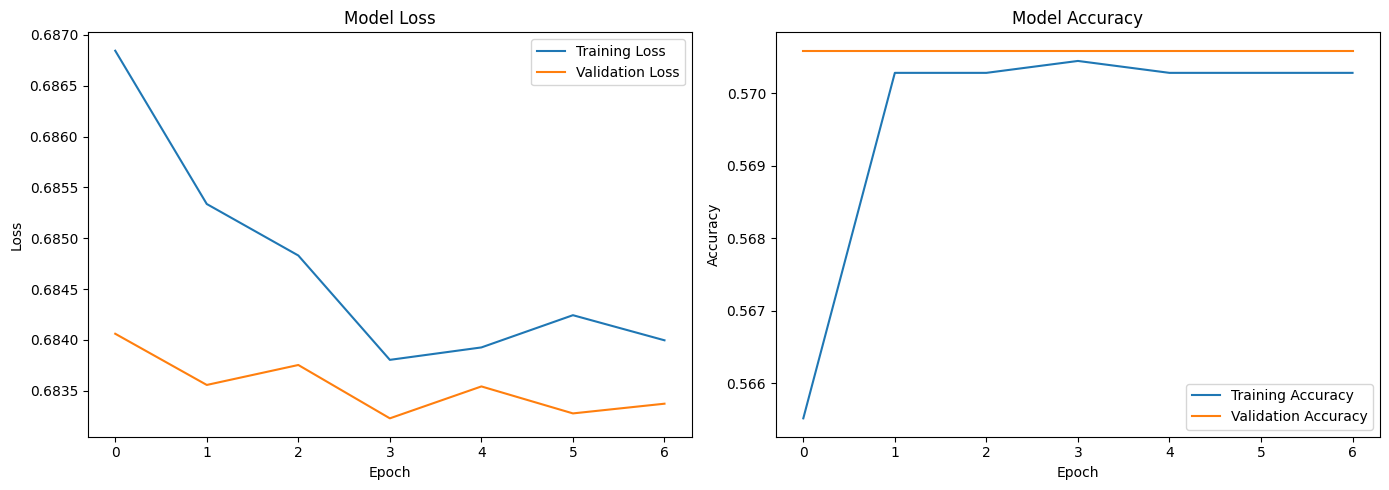

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# 4. Results

In [25]:
y_pred_proba = model.predict(X_val_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step
Validation Accuracy: 0.5705843729481287

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.57      1.00      0.73       869
    Disaster       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


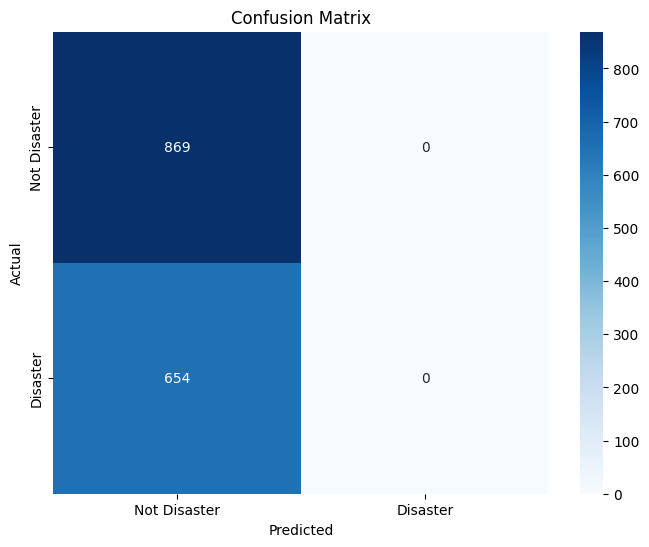

In [26]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 4-1. Hyperparmeter Tuning

* Hyperparameter tuning was performed for lstm_units and dropout_rate. The lstm_units parameter defines the number of neurons in the LSTM layer; if this value is too small, the model may struggle to learn complex patterns in the data, while a value that is too large can lead to overfitting. The dropout_rate sets the ratio for dropout, which helps prevent overfitting by randomly deactivating a certain percentage of neurons during training.

* Three different combinations of lstm_units and dropout_rate were tested. A separate model was built and trained for each combination to compare their performance.

* Due to slow training speeds, the models were trained for only 5 epochs<b>("Korean-To-English Translation")</b>.



In [28]:
hyperparameters = [
   {'lstm_units': 32, 'dropout_rate': 0.3},
   {'lstm_units': 64, 'dropout_rate': 0.5},
   {'lstm_units': 128, 'dropout_rate': 0.5},
]

results = []

for i, params in enumerate(hyperparameters):
   model = lstm_model(**params)

   history = model.fit(
       X_train_pad, y_train,
       epochs=5,
       batch_size=32,
       validation_data=(X_val_pad, y_val),
       callbacks=[early_stopping],
       verbose=0
   )

   val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)

   results.append({
       'config': i+1,
       'params': params,
       'val_loss': val_loss,
       'val_accuracy': val_acc
   })

results_df = pd.DataFrame(results)
results_df.sort_values('val_accuracy', ascending=False)

,config,params,val_loss,val_accuracy
0,1,"{'lstm_units': 32, 'dropout_rate': 0.3}",0.683256,0.570584
1,2,"{'lstm_units': 64, 'dropout_rate': 0.5}",0.683167,0.570584
2,3,"{'lstm_units': 128, 'dropout_rate': 0.5}",0.683369,0.570584


# 5. Conclusion

* Result & Interpretation

 * The accuracy on the validation dataset is approximately 57.1%.

 * Although hyperparameter tuning was conducted, all three tested combinations yielded a validation accuracy of 57.1%, showing no performance improvement over the baseline model.

 * The not Disaster class achieved a Recall of 1.0, while the Precision, Recall, and F1-score for the Disaster class were all measured as 0.

 * This indicates a severe data imbalance problem, where the model simply predicts the majority class (Not disaster) for every input. This is because approximately 57% of the entire dataset is labeled as Not Disaster.

 * Therefore, it can be interpreted that <b>the current model has 'no practical ability to classify disaster tweets.'</b> <b>("Korean-To-English Translation")</b>


* Shortcomings

 * The count for label 1 (Disaster) is 4,342, which is significantly more than the 3,271 for label 0 (Not Disaster). Due to this, it is highly probable that the model learned to simply predict the majority class, as this is the easiest way to increase accuracy.

 * The data preprocessing was minimal. Key steps for cleaning text, such as removing meaningless words (stopwords), were not adequately performed.

 * Instead of using a large, pre-trained embedding model, Word2Vec embeddings were generated using only the small training dataset. This process likely failed to capture the full semantic meaning and context of the words.

 * Standard LSTM has limited contextual understanding because it processes information in only one direction (unidirectionally). An architecture capable of a deeper, bidirectional understanding is needed.

 * A significant limitation was that hyperparameter tuning was restricted to only three combinations due to time and GPU resource constraints.<b>("Korean-To-English Translation")</b>

* Future Improvements

 * It is necessary to guide the model by applying a larger penalty to errors on the minority class during training, forcing it to treat both disaster and non-disaster tweets as equally important.

 * Improve data quality by performing advanced text processing like lemmatization, stemming, and stopword removal using libraries such as NLTK or Spacy.

 * Using pre-trained word embedding models like GloVe is expected to significantly boost model performance

 * Performance can likely be improved by applying a Bidirectional LSTM or an Attention Mechanism. This would enhance the model's understanding of context and allow it to focus more on key information within the tweets.<b>("Korean-To-English Translation")</b>

# 6. Submission

In [29]:
best_config = results_df.loc[results_df['val_accuracy'].idxmax()]
best_params = best_config['params']

best_model = lstm_model(
   lstm_units=best_params['lstm_units'],
   dropout_rate=best_params['dropout_rate']
)

best_model.fit(
   X_train_pad, y_train,
   epochs=20,
   batch_size=32,
   validation_data=(X_val_pad, y_val),
   callbacks=[early_stopping, reduce_lr],
   verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 91s 434ms/step - accuracy: 0.5767 - loss: 0.6844 - val_accuracy: 0.5706 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 440ms/step - accuracy: 0.5823 - loss: 0.6807 - val_accuracy: 0.5706 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 433ms/step - accuracy: 0.5830 - loss: 0.6804 - val_accuracy: 0.5706 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.5830 - loss: 0.6812 - val_accuracy: 0.5706 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 432ms/step - accuracy: 0.5830 - loss: 0.6800 - val_accuracy: 0.5706 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 433ms/step - accuracy: 0.5830 - loss: 0.6804 - val_accuracy: 0.5706 - val_loss: 0.6833 - learning_rate: 5.0000e-04
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.5830 - l

In [30]:
predictions = best_model.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int).flatten()

submission = pd.DataFrame({
   'id': test_df['id'],
   'target': predictions
})

submission.to_csv('submission.csv', index=False)
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [31]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. References

* Yoo, W. (2022, November 29). 09-02 Word2Vec. WikiDocs. https://wikidocs.net/22661

* Mikolov, T., Corrado, G., Chen, K., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.

* "Korean-To-English Translation" prompt. Gemini, Google, 29 July 2025, https://g.co/gemini/share/9efde9116a29

# 8. Github

* https://github.com/mulkib/csca5642.git